In [134]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import warnings

warnings.filterwarnings("ignore")

import math
import torch
import torch.nn
import torch.nn.functional as F
import dgl
import os.path as osp
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics


In [135]:
class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, normalize=False):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))
        self.normalize = normalize

    def forward(self, x, graph, edge_weight=None):
        z = x
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = self.act(z)

        if self.normalize:
            return F.normalize(z, dim=1)
        else:
            return z


class Encoder(nn.Module):
    def __init__(self, graph_dict, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3, normalize=False):
        super(Encoder, self).__init__()

        gconvs = nn.ModuleDict()
        self.cluster_projectors = nn.ModuleDict()
        self.instance_projectors = nn.ModuleDict()
        self.decoder = nn.ModuleDict()

        for k, v in graph_dict.items():
            gconv = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, normalize=normalize).to(device)
            gconvs[k] = gconv
            self.decoder[k] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                # nn.Linear(2 * hidden_dim, 2 * hidden_dim),
                # nn.ELU(),
                nn.Linear(hidden_dim, x.size(1)),
            )
        self.cluster_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, n_clusters),
            nn.Softmax(dim=1)
        )
        self.instance_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.encoder = gconvs
        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, graph_dict, edge_weight=None):
        aug1, aug2 = self.augmentor
        zs = []
        z1s = []
        z2s = []
        c1s = []
        c2s = []
        x_s = []
        for key, (graph, edge_index) in graph_dict.items():
            z = self.encoder[key](x, graph)

            x1, edge_index1, edge_weight1 = x, edge_index, edge_weight
            for aug in aug1:
                x1, edge_index1, _ = aug.augment(x1, edge_index1, edge_weight1)
            # x1, edge_index1, _ = aug1(x, edge_index)
            graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
            graph1.add_self_loop()
            z1 = self.encoder[key](x1, graph1)

            x2, edge_index2, edge_weight2 = x, edge_index, edge_weight
            for aug in aug2:
                x2, edge_index2, _ = aug.augment(x2, edge_index2, edge_weight2)
            # x2, edge_index2, _ = aug2(x, edge_index)
            graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
            graph2.add_self_loop()
            z2 = self.encoder[key](x2, graph2)

            c1 = self.cluster_projector(z1)
            c2 = self.cluster_projector(z2)

            # x_s.append(self.decoder[key](z1))
            # x_s.append(self.decoder[key](z2))

            z1 = self.instance_projector(z1)
            z2 = self.instance_projector(z2)

            x_ = self.decoder[key](self.dropout(z))

            zs.append(z)
            z1s.append(z1)
            z2s.append(z2)
            c1s.append(c1)
            c2s.append(c2)
            x_s.append(x_)

        zs = torch.stack(zs)
        z1s = torch.stack(z1s)
        z2s = torch.stack(z2s)
        c1s = torch.stack(c1s)
        c2s = torch.stack(c2s)
        x_s = torch.stack(x_s)
        return zs, z1s, z2s, c1s, c2s, x_s

    def cluster(self, x, graph_dict, edge_weight=None):
        zs = []
        cs = []
        for key, (graph, edge_index) in graph_dict.items():
            z = self.encoder[key](x, graph)
            c = self.cluster_projector(z)

            zs.append(z)
            cs.append(c)

        return zs, cs


In [136]:
def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


In [137]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))

path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [138]:
print(len(mat['train_idx'][0]))

600


In [139]:
def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


graph_dict = {}
# for etype in ['PAP']:
for etype in ['PAP', 'PLP']:
# for etype in ['net_APCPA', 'net_APTPA', 'net_APA']:
    # for etype in ['net_APCPA', 'net_APA']:
    # for etype in ['MDM', 'MAM']:
    adj = load_graph(mat[etype]).to(device)
    graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat[etype])).to(device)
    graph.remove_self_loop()
    graph.add_self_loop()
    edge_index = torch.stack(graph.edges())
    graph_dict[etype] = (graph, edge_index)

In [140]:
print(graph_dict)

{'PAP': (Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,    8,   20,  ..., 2983, 2991, 3024]], device='cuda:0')), 'PLP': (Graph(num_nodes=3025, num_edges=2210761,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,   75,  434,  ..., 3021, 3022, 3024]], device='cuda:0'))}


In [141]:
from sklearn.decomposition import PCA

x = tensor(mat['feature'], dtype=torch.float).to(device)
# pca = PCA(n_components=0.90)
# x = pca.fit_transform(mat['features'])
# x = tensor(x, dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)


In [142]:
del mat


model have 2382239 paramerters in total


(T): 100%|█| 1000/1000 [00:56<00:00, 17.64it/s, loss=15.7, con_loss=15.6, clu_loss=0.0858, acc=0.91


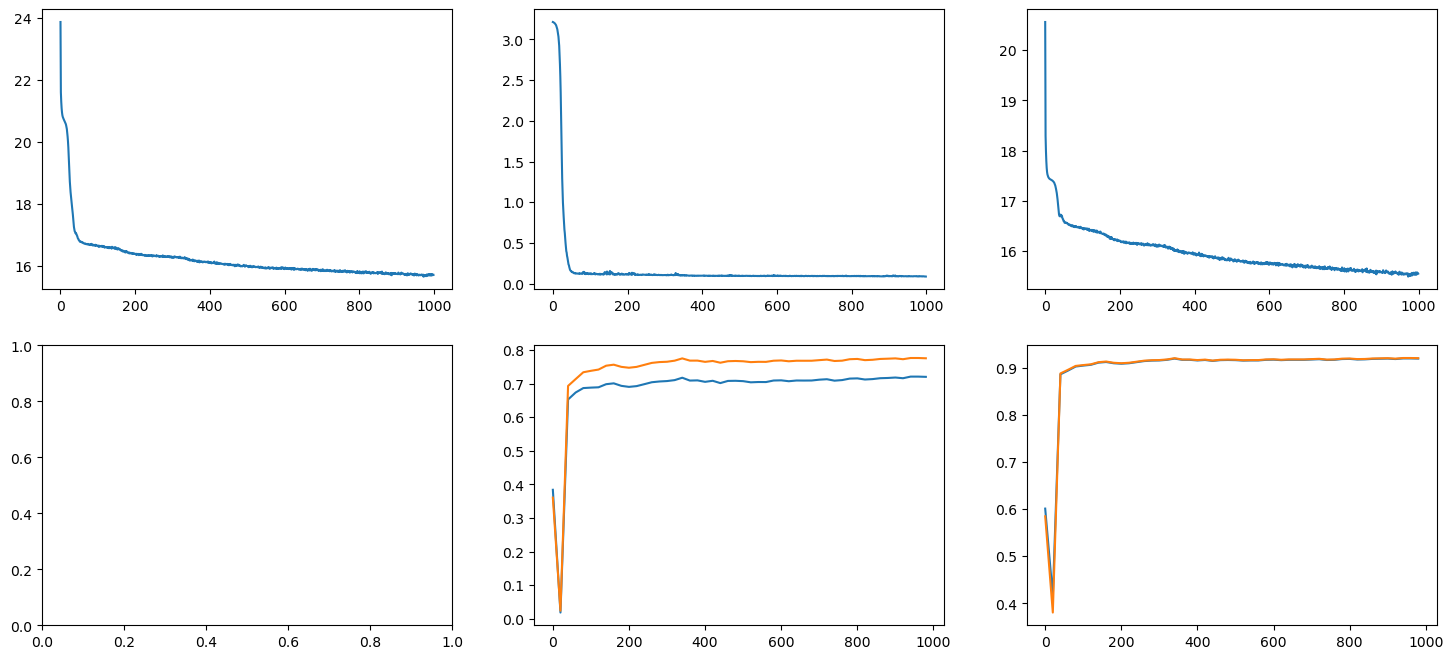

[MAX]NMI:  0.7205663870068303
[MAX]ARI:  0.7759025914407558
[MAX]ACC:  0.9196694214876033
[MAX]F1:  0.9205805343585093


In [148]:


def train2(encoder_model, contrast_model, cluster_model, optimizer, x, graph_dict):
    encoder_model.train()
    optimizer.zero_grad()
    zs, z1s, z2s, c1s, c2s, x_s = encoder_model(x, graph_dict)
    con_loss = 0
    # for i in range(len(z1s)):
    #     con_loss += contrast_model(z1s[i], z2s[i])
    # for i in range(len(z1s)):
    #     con_loss += contrast_model2(z1s[i], z2s[int((i + 1) % len(z1s))])

    for i in range(1, len(z1s)):
        con_loss += contrast_model(z1s[0], z1s[i])
        con_loss += contrast_model(z2s[0], z2s[i])

    # con_loss += contrast_model2(z1s[1], z1s[2])
    # con_loss += contrast_model2(z2s[1], z2s[2])
    # con_loss += contrast_model2(z1s[0], z2s[1])
    # for i in range(1, len(z1s)):
    #     con_loss += F.mse_loss(zs[0], zs[i])
    # con_loss += F.mse_loss(z2s[0], z2s[i])
    clu_loss = 0
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i].t(), c2s[i].t())
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    for i in range(len(z1s)):
        c1 = c1s[i]
        c2 = c2s[i]
        p1 = c1.sum(0).view(-1)
        p1 /= p1.sum()
        ne1 = math.log(p1.size(0)) + (p1 * torch.log(p1)).sum()
        p2 = c2.sum(0).view(-1)
        p2 /= p2.sum()
        ne2 = math.log(p2.size(0)) + (p2 * torch.log(p2)).sum()
        clu_loss += cluster_model(c1s[i].t(), c2s[i].t()) + ne1 + ne2

    # for i in range(1, len(z1s)):
    #     c1 = c1s[0]
    #     c2 = c2s[i]
    #     p1 = c1.sum(0).view(-1)
    #     p1 /= p1.sum()
    #     ne1 = math.log(p1.size(0)) + (p1 * torch.log(p1)).sum()
    #     p2 = c2.sum(0).view(-1)
    #     p2 /= p2.sum()
    #     ne2 = math.log(p2.size(0)) + (p2 * torch.log(p2)).sum()
    #     clu_loss += cluster_model(c1s[i].t(), c2s[i].t()) + (ne1 + ne2)
    #
    # for i in range(1, len(z1s)):
    #     c1 = c1s[i]
    #     c2 = c2s[0]
    #     p1 = c1.sum(0).view(-1)
    #     p1 /= p1.sum()
    #     ne1 = math.log(p1.size(0)) + (p1 * torch.log(p1)).sum()
    #     p2 = c2.sum(0).view(-1)
    #     p2 /= p2.sum()
    #     ne2 = math.log(p2.size(0)) + (p2 * torch.log(p2)).sum()
    #     clu_loss += cluster_model(c1s[i].t(), c2s[i].t()) + (ne1 + ne2)

    re_loss = 0
    for i in range(len(x_s)):
        re_loss += F.mse_loss(x, x_s[i])
    # clu_loss += cluster_model(c1s[0].t(), c2s[0].t())
    loss = con_loss + clu_loss + re_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item(), re_loss.item()


# class EdgeRemoving:
#     def __init__(self, pe: float, n_node: int):
#         self.pe = pe
#         self.n_node = n_node
#
#     def augment(self, x, edge_index, edge_weights):
#         edge_mask = self.mask_edge(self.pe, self.n_node)
#
#         src = edge_index[0]
#         dst = edge_index[1]
#
#         nsrc = src[edge_mask]
#         ndst = dst[edge_mask]
#         edge_index = torch.stack([nsrc, ndst], dim=0)
#         return x, edge_index, edge_weights
#
#     def mask_edge(self, mask_prob, n_node):
#         E = n_node
#
#         mask_rates = torch.FloatTensor(np.ones(E) * mask_prob)
#         masks = torch.bernoulli(1 - mask_rates)
#         mask_idx = masks.nonzero().squeeze(1)
#         return mask_idx


class EdgeRemoving:
    def __init__(self, pe: float):
        self.pe = pe

    def augment(self, x, edge_index, edge_weights):
        row, col = edge_index
        mask = torch.rand(row.size(0), device=edge_index.device) >= self.pe
        row, col, edge_attr = row[mask], col[mask], None if edge_weights is None else edge_weights[mask]
        edge_index = torch.stack([row, col], dim=0)
        return x, edge_index, edge_weights


class FeatureDropout:
    def __init__(self, pf: float):
        self.pf = pf

    def augment(self, x, edge_index, edge_weights):
        x = F.dropout(x, p=1. - self.pf)
        return x, edge_index, edge_weights


class InfoNCE(nn.Module):
    def __init__(self, tau):
        super(InfoNCE, self).__init__()
        self.tau = tau

    def sim(self, z1, z2):
        # normalize embeddings across feature dimension
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)

        s = torch.mm(z1, z2.t())
        return s

    def get_loss(self, z1, z2):
        # calculate SimCLR loss
        f = lambda x: torch.exp(x / self.tau)

        refl_sim = f(self.sim(z1, z1))  # intra-view pairs
        between_sim = f(self.sim(z1, z2))  # inter-view pairs

        # between_sim.diag(): positive pairs
        x1 = refl_sim.sum(1) + between_sim.sum(1) - refl_sim.diag()
        loss = -torch.log(between_sim.diag() / x1)

        return loss.mean()

    def forward(self, z1, z2):
        l1 = self.get_loss(z1, z2)
        l2 = self.get_loss(z2, z1)

        ret = (l1 + l2) * 0.5

        # return ret.mean()
        return ret


aug1 = (EdgeRemoving(pe=0.3), FeatureDropout(pf=0.5))
aug2 = (EdgeRemoving(pe=0.3), FeatureDropout(pf=0.5))

# aug1 = A.Identity()
# aug1 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.5)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.5)])

encoder_model = Encoder(graph_dict=graph_dict, augmentor=(aug1, aug2), hidden_dim=256, num_heads=1, n_clusters=3,
                        num_layers=2, normalize=False).to(device)
print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
contrast_model = InfoNCE(tau=0.2).to(device)
# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
# contrast_model2 = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=False).to(device)
# contrast_model2 = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
# cluster_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
cluster_model = InfoNCE(tau=0.2).to(device)
# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
# optimizer1 = Adam(encoder_model.parameters(), lr=0.0003, weight_decay=1e-5)

# DBLP
# optimizer = Adam(encoder_model.parameters(), lr=0.00005, weight_decay=1e-5)

# ACM
optimizer = Adam(encoder_model.parameters(), lr=0.0005, weight_decay=1e-5)

losss = []
clu_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs1 = 0
epochs2 = 1000
epochs3 = 0

kmeans = KMeans(n_clusters=3, n_init=20)

# with tqdm(total=epochs1, desc='(T)') as pbar:
#     for epoch in range(epochs1):
#         encoder_model.train()
#
#         loss, con_loss = train1(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer1, x,
#                                 graph_dict)
#         pbar.set_postfix({'loss': loss, 'con_loss': con_loss})
#         pbar.update()
acc = 0
with tqdm(total=epochs2, desc='(T)') as pbar:
    for epoch in range(epochs2):
        encoder_model.train()

        loss, con_loss, clu_loss, re_loss = train2(encoder_model, contrast_model, cluster_model,
                                                   optimizer, x,
                                                   graph_dict)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'clu_loss': clu_loss, 'acc': acc})
        pbar.update()
        losss.append(loss)
        clu_losss.append(clu_loss)
        con_losss.append(con_loss)

        if epoch % 20 == 0:
            with torch.no_grad():
                encoder_model.eval()
                zs, _, _, _, _, _ = encoder_model(x, graph_dict)
            z = torch.cat(tuple([z for z in zs]), dim=1)
            # z = zs[0]
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs2), losss)
axes[0][1].plot(range(epochs2), clu_losss)
axes[0][2].plot(range(epochs2), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


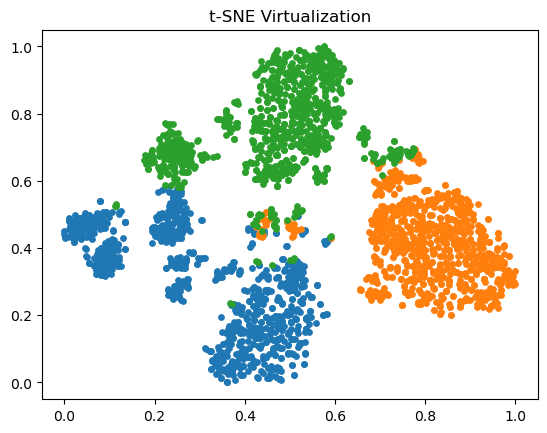

In [149]:

from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = torch.cat(tuple([z for z in zs]), dim=1)
    # z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()



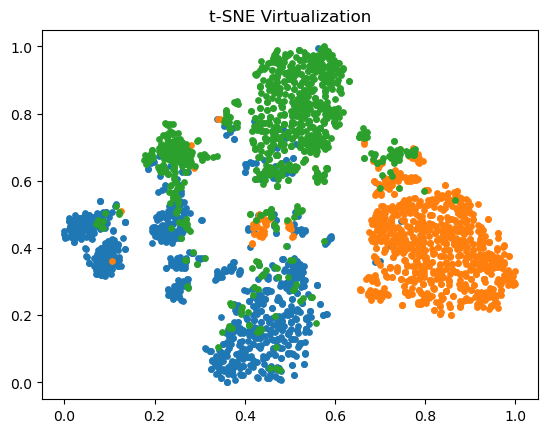

In [150]:
d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [151]:

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = torch.cat(tuple([z for z in zs]), dim=1)
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0] + zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z0', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z1', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0] + zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, cs = encoder_model.cluster(x, graph_dict)
    pred = torch.argmax(cs[0], -1).cpu().numpy()
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

0.7784373758246553 0.7230362752010042 0.9206611570247933 0.9215614973262033
0.763713981705247 0.7091013575258376 0.9147107438016528 0.915538864580603
z0 0.7674439794303184 0.7081542094965843 0.9163636363636364 0.9168268125634649
z1 0.41940736448362304 0.43482077965546984 0.6889256198347108 0.6866575336263367
0.763713981705247 0.7091013575258378 0.9147107438016528 0.915538864580603
0.7683427486033769 0.7104755655147459 0.9166942148760331 0.9171384212058994


In [152]:

z = torch.cat((zs[0], zs[1]), dim=1)
print(z.size())

torch.Size([3025, 512])
